In [3]:
# IMPORTS

from math import sqrt
from scipy.signal import argrelextrema
import random
import csv
import scipy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

from time import time
import os.path

from socket import gethostname
from scipy.optimize import curve_fit

%config InlineBackend.figure_formats = ['svg']

In [36]:
def rmse(predictions, targets):
    """
    predictions: data points generated from fit
    targets: actual data points
    
    Calculates root mean square error for each data point
    """
    return np.sqrt(((predictions - targets) ** 2).mean())

def normalize(fun):

    vert_shift = fun(0)
    deriv = list(fun._spline.derivative(nu=1)(syns))
    max_i = 0
    max_val = 0
    for i, d in enumerate(deriv):
        if d > max_val and (i > 5 and i < 25):
            max_val = d
            max_i = i
    max_i_val = fun(max_i)
    x_normal = np.linspace(0, 1, num=max_i+1)
    y_normal = (fun(range(0, max_i+1)) - vert_shift) / (max_i_val - vert_shift)
    normal_fun = scipy.interpolate.interp1d(x_normal, y_normal, kind='cubic', bounds_error=False, fill_value="extrapolate")
    return normal_fun

def si_func(fi_i, fi_f, fs_f):

    pop_vec = []
    prev_el = -1
    for i, el in enumerate(fi_f):
        if (el + 0.002 > prev_el) and (el - 0.002 < prev_el):
            pop_vec.append(i)
        prev_el = el
    fi_f = np.delete(fi_f, pop_vec)
    fi_i = np.delete(fi_i, pop_vec)
    
    if_fun = scipy.interpolate.interp1d(fi_f, fi_i, kind='cubic', bounds_error=False, fill_value="extrapolate")
    si_fun = scipy.interpolate.interp1d(syns, if_fun(fs_f), kind='cubic', bounds_error=False, fill_value="extrapolate")
    return si_fun

def angle(fun, x):
    theta = np.arctan(fun._spline.derivative(nu=1)(x))
    return theta

def pathlength(fun):
    dx = 0.0001
    x_vec = np.arange(0, 1, dx)
    y_vec = fun(x_vec)
    n = len(x_vec) 
    lv = [np.sqrt((x_vec[i]-x_vec[i-1])**2 + (y_vec[i]-y_vec[i-1])**2) for i in range (1,n)]
    lv_sum = [0]
    for i in range(0, n-1):
        lv_sum.append(lv[i] + lv_sum[i-1])
    return lv_sum

def normal_plot(fun):
    fig_n, axs_n = plt.subplots(figsize=(5, 3))
    x = np.linspace(0, 1, num=100)
    axs_n.plot(x, fun(x))
    axs_n.set_xlabel('Input (Scaled)', fontsize=14)
    axs_n.set_ylabel('Output (Scaled)', fontsize=14)
    axs_n.set_title('Normalized Dendritic I/O Curve', fontsize=14)
    axs_n.grid(visible=True, which='major')

def angle_plot(fun, plot=True):
    dx = 0.0001
    x = np.arange(0, 1, dx)
    angle_vec = angle(fun, x) * 180 / np.pi
    len_vec = pathlength(fun)
    
    if plot:
        fig_a, axs_a = plt.subplots(figsize=(5,3))
        axs_a.plot(len_vec, angle_vec)
        axs_a.set_xlabel('Curve Pathlength', fontsize=14)
        axs_a.set_ylabel('Tangential Angle (Ø)', fontsize=14)
        axs_a.set_title('Angle of Curve', fontsize=14)
        axs_a.grid(visible=True, which='major')
        
    max_a = np.max(angle_vec)
    
    return max_a
    
def angle_deriv_plot(fun, plot=True):
    dx = 0.0001
    x = np.arange(0, 1, dx)
    len_vec = pathlength(fun)
    angle_vec = angle(fun, x) * 180 / np.pi
    n = len(angle_vec)
    angle_deriv = [angle_vec[i] - angle_vec[i-1] for i in range(1, n)]
    
    if plot:
        fig_d, axs_d = plt.subplots(figsize=(5,3))
        axs_d.plot(len_vec[:-1], angle_deriv)
        axs_d.set_xlabel('Curve Pathlength', fontsize=14)
        axs_d.set_ylabel('Angle Rate of Change (dØ/ds)', fontsize=14)
        axs_d.set_title('Derivative of Curve Angle', fontsize=14)
        axs_d.grid(visible=True, which='major')
        
    max_deriv_i = argrelextrema(np.array(angle_deriv), np.greater)[0]
    n_i = len(max_deriv_i)
    max_deriv = 0
    
    for i in range(1, n_i):
        if angle_deriv[max_deriv_i[i]] > max_deriv:
            max_deriv = angle_deriv[max_deriv_i[i]][0]
            
    return max_deriv

def nonlinear_score_plot(x, angle_vec, deriv_vec, xlab):
    fig_d, axs_d = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)
    w = 0.8 * (x[1] - x[0])
    axs_d[0].bar(x, angle_vec, width=w)
    axs_d[0].set_ylabel('Maximum Curve Angle ($Ø_{Max}$)')
    axs_d[0].set_xlabel(xlab)
    axs_d[1].bar(x, deriv_vec, width=w)
    axs_d[1].set_ylabel('Maximum Derivative of Curve Angle ($dØ/ds_{Max}$)')
    axs_d[1].set_xlabel(xlab)
    



In [37]:
# LOAD SIGMOID CURVE DATA
t_o = 13
f_file_path = "SLURM-jobs/timing-variation/fs-curve-collection/fs-collection-timing-compiled-shorter-tau/timing-offset-fs-" + str(t_o) + ".csv"
f = np.loadtxt(f_file_path, delimiter=",")
syns = np.array(range(0, len(f)))

f_current_file_path = "SLURM-jobs/timing-variation/fi-curve-collection/fi-timing-higher-conductance-lower-tau.csv"
f_current = np.loadtxt(f_current_file_path, delimiter=",")
inj_i = f_current[:, 0]
f_i = f_current[:, 1]
i_interp = si_func(inj_i, f_i, f)

0.19057567119591212

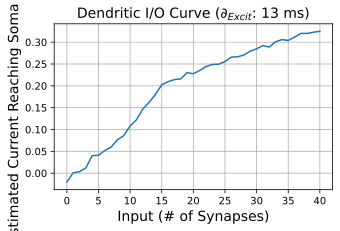

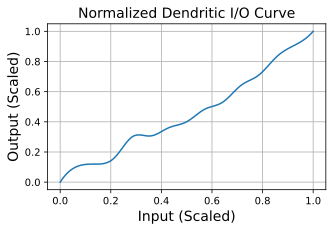

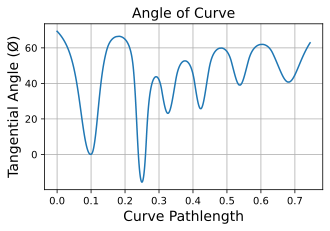

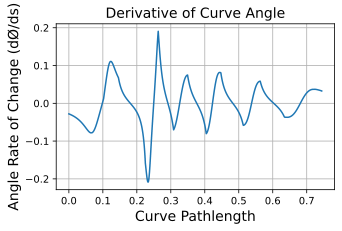

In [38]:
# Individual Dendritic I/O Curve

fig_i, axs_i = plt.subplots(figsize=(5,3))
plt.plot(syns, i_interp(syns))
axs_i.set_xlabel('Input (# of Synapses)', fontsize=14)
axs_i.set_ylabel('Estimated Current Reaching Soma (nA)', fontsize=14)
title_string = 'Dendritic I/O Curve ($∂_{Excit}$: ' + str(t_o) + ' ms)'
axs_i.set_title(title_string, fontsize=14)
axs_i.grid(visible=True, which='major')
normal = normalize(i_interp)
normal_plot(normal)
angle_plot(normal)
angle_deriv_plot(normal)

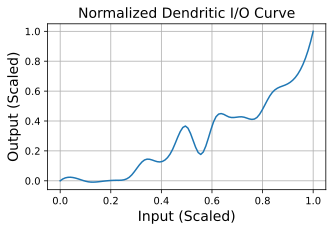

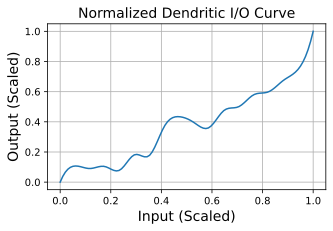

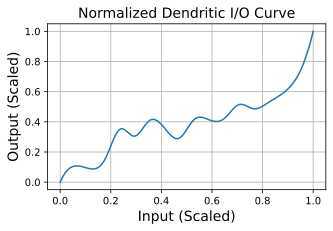

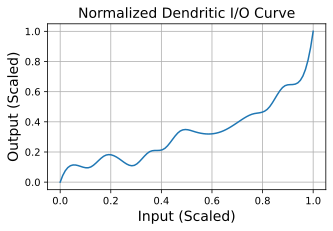

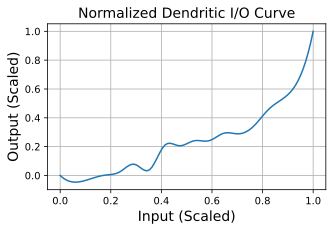

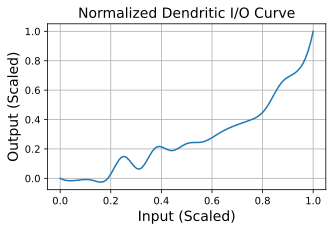

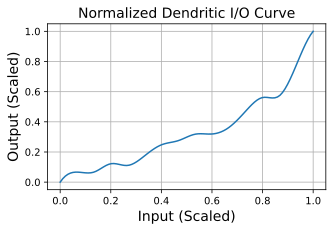

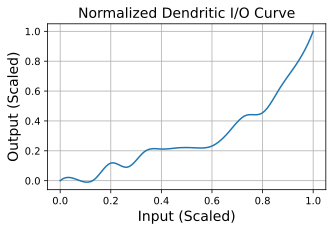

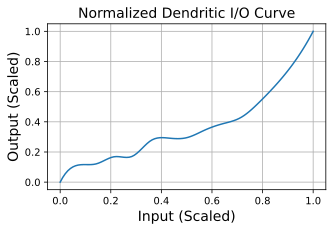

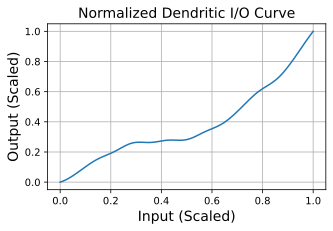

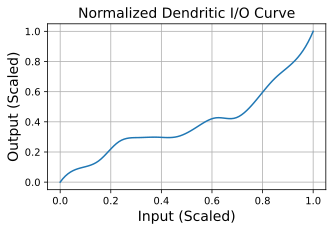

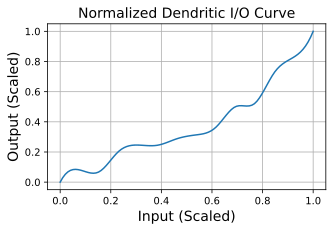

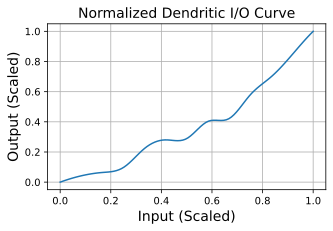

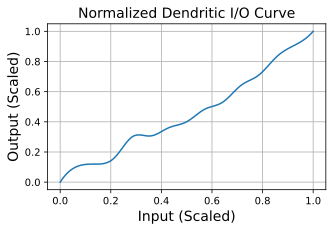

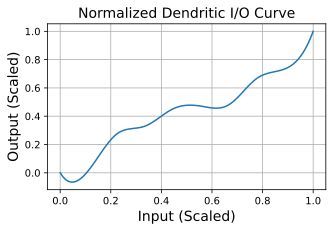

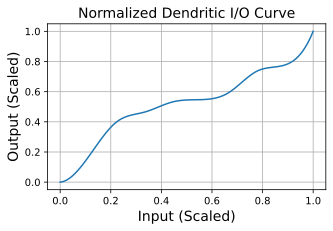

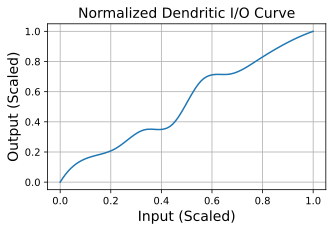

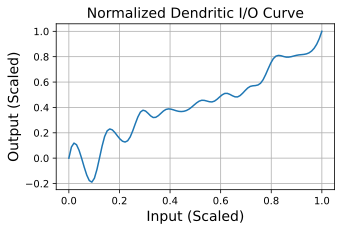

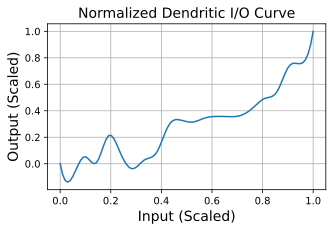

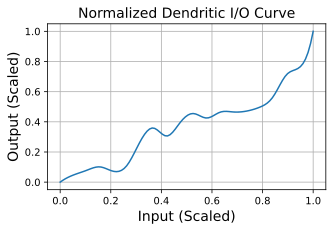

In [48]:
# Nonlinear Score Calculator - Timing Offset

ang_vec = []
der_vec = []

for t_o in range(0, 20):
    f_file_path = "SLURM-jobs/timing-variation/fs-curve-collection/fs-collection-timing-compiled-shorter-tau/timing-offset-fs-" + str(t_o) + ".csv"
    f = np.loadtxt(f_file_path, delimiter=",")
    syns = np.array(range(0, len(f)))
    
    f_current_file_path = "SLURM-jobs/timing-variation/fi-curve-collection/fi-timing-higher-conductance-lower-tau.csv"
    f_current = np.loadtxt(f_current_file_path, delimiter=",")
    inj_i = f_current[:, 0]
    f_i = f_current[:, 1]
    i_interp = si_func(inj_i, f_i, f)

    normal = normalize(i_interp)
    normal_plot(normal)
    ang_vec.append(angle_plot(normal, plot=False))
    der_vec.append(angle_deriv_plot(normal, plot=False))
    
    

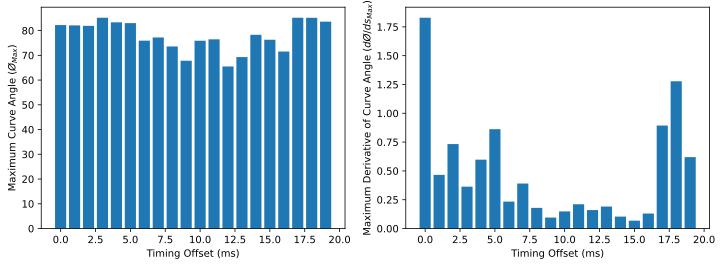

In [50]:
nonlinear_score_plot(range(20), ang_vec, der_vec, xlab="Timing Offset (ms)")

In [15]:
# Nonlinear Score Calculator - Variable Inhibition

ang_vec = []
der_vec = []

for trial in range(3, 16):
    f_file_path = "SLURM-jobs/variable-inhibition/fs-curve-collection/fs-collection-compiled/variable-inhibition-fs-" + str(trial) + ".csv"
    f = np.loadtxt(f_file_path, delimiter=",")
    syns = np.array(range(0, len(f)))
    
    f_current_file_path = "SLURM-jobs/variable-inhibition/fi-curve-collection/fi-collection-compiled/variable-inhibition-fi-" + str(trial) + ".csv"
    f_current = np.loadtxt(f_current_file_path, delimiter=",")
    inj_i = f_current[:, 0]
    f_i = f_current[:, 1]
    i_interp = si_func(inj_i, f_i, f)
    
    normal = normalize(i_interp)
    ang_vec.append(angle_plot(normal, plot=False))
    der_vec.append(angle_deriv_plot(normal, plot=False))




/var/folders/gn/nmp7t3s51b34z7c2mk853cr40000gn/T/ipykernel_8994/2861134741.py:17: RuntimeWarning: invalid value encountered in divide
  y_normal = (fun(range(0, max_i+1)) - vert_shift) / (max_i_val - vert_shift)


ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

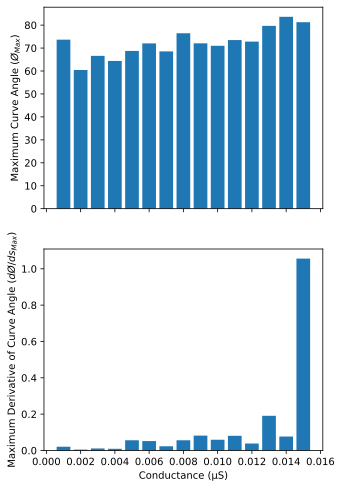

In [59]:
nonlinear_score_plot(list(np.arange(0.001, 0.016, 0.001)), ang_vec, der_vec, xlab="Conductance (µS)")